# Representative State Matrices 

## preprocess and packages

In [1]:
import numpy as np 
import matplotlib .pyplot as plt 
import pandas as pd

In [2]:
df = pd.read_csv("dataset\energy_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [4]:
N = 8

In [5]:
# Cargar datos de ejemplo
def load_energy_data():

    return df


## processing function to create a matrix from X num_states (in order to quantify the data) and plot their transition matrix


In [6]:
import numpy as np
def create_transition_matrix(series, num_states):
    # 1. Discretizar la serie en 'num_states' estados
    bins = np.linspace(min(series), max(series), num_states + 1)
    states = np.digitize(series, bins) - 1  # Restar 1 para que los índices comiencen en 0

    # Asegurarse de que los estados estén en el rango [0, num_states-1]
    states = np.clip(states, 0, num_states - 1)

    # 2. Crear matriz de transición
    trans_matrix = np.zeros((num_states, num_states), dtype=int)
    for i in range(len(states) - 1):
        from_state = states[i]
        to_state = states[i + 1]
        trans_matrix[from_state, to_state] += 1

    # 3. Normalizar filas para obtener probabilidades
    row_sums = trans_matrix.sum(axis=1, keepdims=True)
    trans_matrix = np.divide(trans_matrix, row_sums, where=row_sums != 0)

    return trans_matrix

## process for first pair 

In [ ]:

# Procesamiento principal
def FirstPar():
    # Cargar datos
    df = load_energy_data()
    
    # Seleccionar serie temporal (cambiar según necesidad)
    series = df['generation solar'].values  # o 'total_load_actual'
    series2= df['total load actual'].values
    
    # Crear matriz de transición 8x8
    trans_matrix = create_transition_matrix(series, num_states=8)
    trans_matrix2 = create_transition_matrix(series2, num_states=8)



    # Compute column sums for each transition matrix
    column_sums_1 = trans_matrix.sum(axis=0)  # Column-wise sum for matrix 1
    column_sums_2 = trans_matrix2.sum(axis=0)  # Column-wise sum for matrix 2

    
    # visualization 

    fig, axes = plt.subplots( 3, 2, figsize = (12,15)) # 3 rows and 2 columns

    #heat map for T1 and T2

    # Heatmap for Transition Matrix 1
    im1 = axes[0, 0].imshow(trans_matrix, cmap="viridis", aspect="auto")
    axes[0, 0].set_title("Transition Matrix 1 Heatmap")
    fig.colorbar(im1, ax=axes[0, 0])
    axes[0, 0].set_xlabel("To State")
    axes[0, 0].set_ylabel("From State")

    # Mostrar valores en las celdas para Transition Matrix 1
    for i in range(trans_matrix.shape[0]):
        for j in range(trans_matrix.shape[1]):
            axes[0, 0].text(j, i, f"{trans_matrix[i, j]:.2f}", 
                            ha="center", va="center", color="white")


    # Bar plot for Column Sums of Transition Matrix 1
    axes[1, 0].bar(range(N), column_sums_1/column_sums_1.sum(axis=0), color="blue", alpha=0.7)
    axes[1, 0].set_title("Column Sums of Transition Matrix 1")
    axes[1, 0].set_xlabel("Column Index")
    axes[1, 0].set_ylabel("Sum")


    # Heatmap for Transition Matrix 2
    im2 = axes[0, 1].imshow(trans_matrix2, cmap="viridis", aspect="auto")
    axes[0, 1].set_title("Transition Matrix 2 Heatmap")
    fig.colorbar(im2, ax=axes[0, 1])
    axes[0, 1].set_xlabel("To State")
    axes[0, 1].set_ylabel("From State")

    # Mostrar valores en las celdas para Transition Matrix 2
    for i in range(trans_matrix2.shape[0]):
        for j in range(trans_matrix2.shape[1]):
            axes[0, 1].text(j, i, f"{trans_matrix2[i, j]:.2f}", 
                            ha="center", va="center", color="white")
        

    # Bar plot for Column Sums of Transition Matrix 2
    axes[1, 1].bar(range(N), column_sums_2/column_sums_2.sum(axis=0), color="green", alpha=0.7)
    axes[1, 1].set_title("Column Sums of Transition Matrix 2")
    axes[1, 1].set_xlabel("Column Index")
    axes[1, 1].set_ylabel("Sum")





    # Compute eigenvalues for each transition matrix
    eigenvalues_1 = np.linalg.eigvals(trans_matrix)
    axes[2, 0].bar(range(len(eigenvalues_1)), eigenvalues_1.real, color="blue", alpha=0.7)
    axes[2, 0].set_title("Eigenvalues of Transition Matrix 1")
    axes[2, 0].set_xlabel("Eigenvalue Index")
    axes[2, 0].set_ylabel("Real Part")

    eigenvalues_2 = np.linalg.eigvals(trans_matrix2)
    axes[2, 1].bar(range(len(eigenvalues_2)), eigenvalues_2.real, color="green", alpha=0.7)
    axes[2, 1].set_title("Eigenvalues of Transition Matrix 2")
    axes[2, 1].set_xlabel("Eigenvalue Index")
    axes[2, 1].set_ylabel("Real Part")

    plt.tight_layout()
    plt.show()



    # Compute joint transition matrix
    joint_matrix = np.dot(trans_matrix, trans_matrix2)  # Matrix multiplication

    # Compute column sums for the joint matrix
    column_sums_joint = joint_matrix.sum(axis=0)

    # Compute eigenvalues for the joint matrix
    eigenvalues_joint = np.linalg.eigvals(joint_matrix)

    # Plot heatmap, column sums, and eigenvalues for the joint matrix
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 rows, 1 column

    # Heatmap for Joint Transition Matrix
    im = axes[0].imshow(joint_matrix, cmap="viridis", aspect="auto")
    axes[0].set_title("Joint Transition Matrix Heatmap")
    fig.colorbar(im, ax=axes[0])
    axes[0].set_xlabel("To State")
    axes[0].set_ylabel("From State")

    # Bar plot for Column Sums of Joint Transition Matrix
    axes[1].bar(range(N), column_sums_joint/column_sums_joint.sum(axis=0), color="blue", alpha=0.7)
    axes[1].set_title("Column Sums of Joint Transition Matrix")
    axes[1].set_xlabel("Column Index")
    axes[1].set_ylabel("Sum")

    # Bar plot for Eigenvalues of Joint Transition Matrix
    axes[2].bar(range(len(eigenvalues_joint)), eigenvalues_joint.real, color="green", alpha=0.7)
    axes[2].set_title("Eigenvalues of Joint Transition Matrix")
    axes[2].set_xlabel("Eigenvalue Index")
    axes[2].set_ylabel("Real Part")

    plt.tight_layout()
    plt.show()
    return trans_matrix, trans_matrix2, joint_matrix, column_sums_1, column_sums_2, column_sums_joint, eigenvalues_1, eigenvalues_2, eigenvalues_joint
    

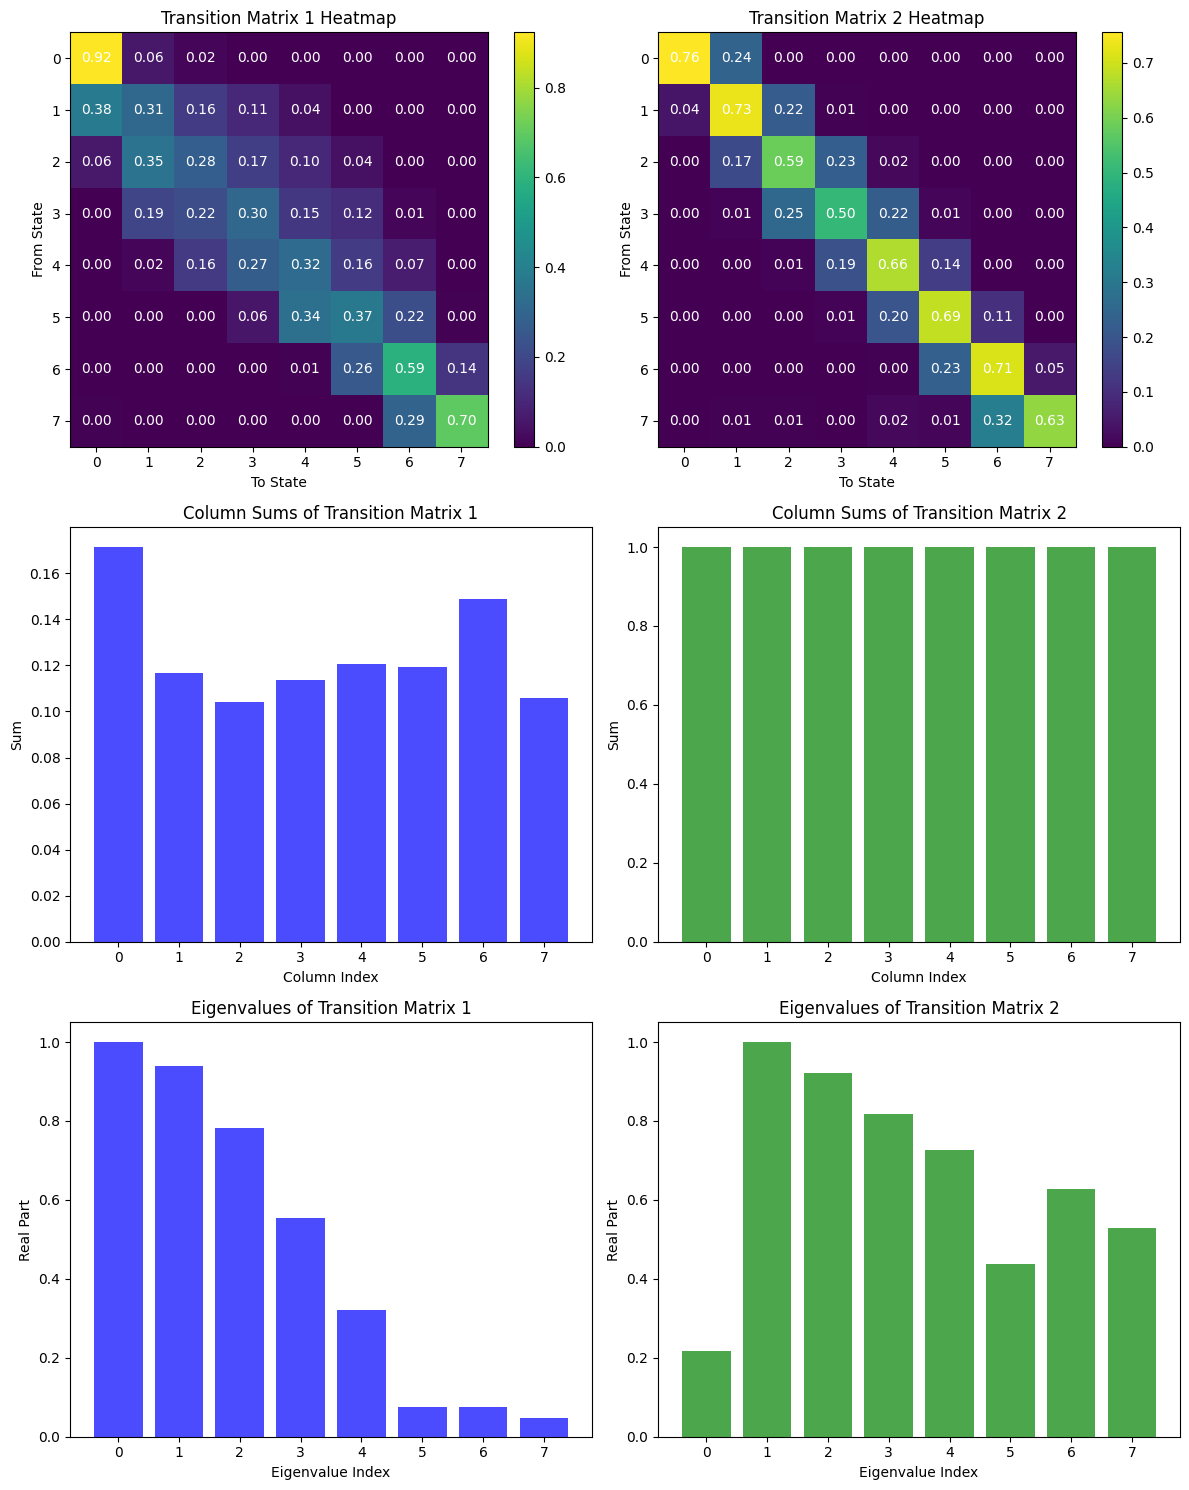

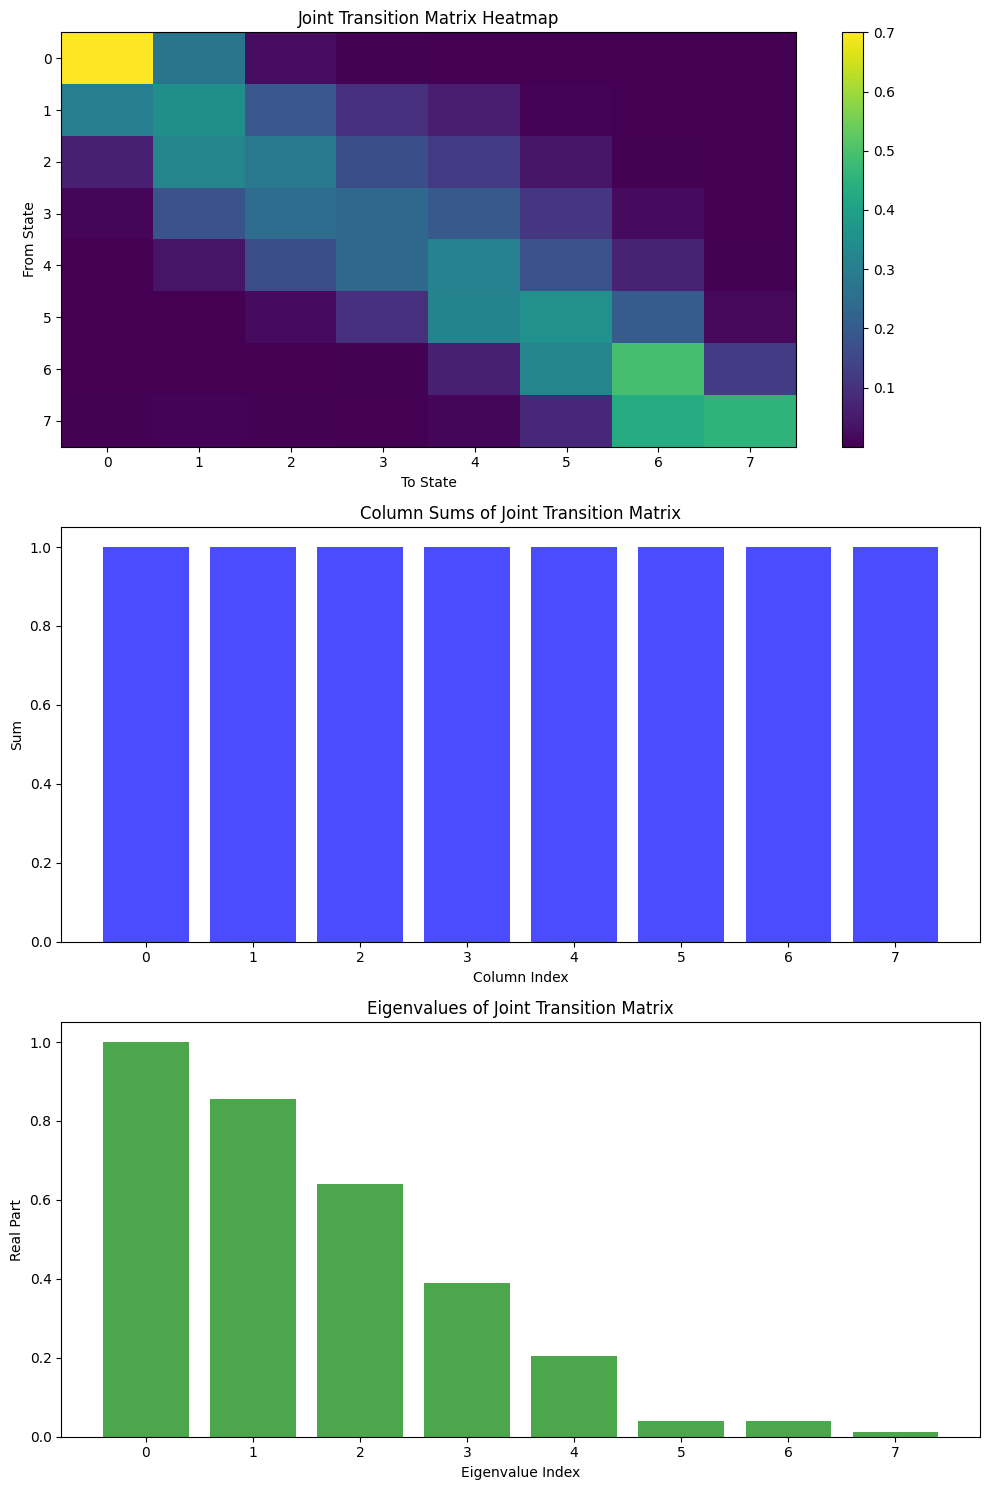

In [16]:

if __name__ == "__main__":

    join_matrixFirstCase = FirstPar()[2]

## process for second pair 

In [9]:

# Procesamiento principal
def secondPair():
    # Cargar datos
    df = load_energy_data()
    
    # Seleccionar serie temporal (cambiar según necesidad)
    series3 = df['generation nuclear'].values  # o 'total_load_actual'
    series4= df['price actual'].values
    
    # Crear matriz de transición 8x8
    trans_matrix3 = create_transition_matrix(series3, num_states=8)
    trans_matrix4 = create_transition_matrix(series4, num_states=8)



    # Compute column sums for each transition matrix
    column_sums_3 = trans_matrix3.sum(axis=0)  # Column-wise sum for matrix 1
    column_sums_4 = trans_matrix4.sum(axis=0)  # Column-wise sum for matrix 2

    
    # visualization 

    fig, axes = plt.subplots( 3, 2, figsize = (12,15)) # 3 rows and 2 columns

    #heat map for T1 and T2

    # Heatmap for Transition Matrix 1
    im1 = axes[0, 0].imshow(trans_matrix3, cmap="viridis", aspect="auto")
    axes[0, 0].set_title("Transition Matrix 3 Heatmap")
    fig.colorbar(im1, ax=axes[0, 0])
    axes[0, 0].set_xlabel("To State")
    axes[0, 0].set_ylabel("From State")

    # Mostrar valores en las celdas para Transition Matrix 1
    for i in range(trans_matrix3.shape[0]):
        for j in range(trans_matrix3.shape[1]):
            axes[0, 0].text(j, i, f"{trans_matrix3[i, j]:.2f}", 
                            ha="center", va="center", color="white")


    # Bar plot for Column Sums of Transition Matrix 1
    axes[1, 0].bar(range(N), column_sums_3/column_sums_3.sum(axis=0), color="blue", alpha=0.7)
    axes[1, 0].set_title("Column Sums of Transition Matrix 3")
    axes[1, 0].set_xlabel("Column Index")
    axes[1, 0].set_ylabel("Sum")


    # Heatmap for Transition Matrix 2
    im2 = axes[0, 1].imshow(trans_matrix4, cmap="viridis", aspect="auto")
    axes[0, 1].set_title("Transition Matrix 4 Heatmap")
    fig.colorbar(im2, ax=axes[0, 1])
    axes[0, 1].set_xlabel("To State")
    axes[0, 1].set_ylabel("From State")

    # Mostrar valores en las celdas para Transition Matrix 2
    for i in range(trans_matrix4.shape[0]):
        for j in range(trans_matrix4.shape[1]):
            axes[0, 1].text(j, i, f"{trans_matrix4[i, j]:.2f}", 
                            ha="center", va="center", color="white")
        

    # Bar plot for Column Sums of Transition Matrix 2
    axes[1, 1].bar(range(N), column_sums_4/column_sums_4.sum(axis=0), color="green", alpha=0.7)
    axes[1, 1].set_title("Column Sums of Transition Matrix 4")
    axes[1, 1].set_xlabel("Column Index")
    axes[1, 1].set_ylabel("Sum")





    # Compute eigenvalues for each transition matrix
    eigenvalues_3 = np.linalg.eigvals(trans_matrix3)
    axes[2, 0].bar(range(len(eigenvalues_3)), eigenvalues_3.real, color="blue", alpha=0.7)
    axes[2, 0].set_title("Eigenvalues of Transition Matrix 3")
    axes[2, 0].set_xlabel("Eigenvalue Index")
    axes[2, 0].set_ylabel("Real Part")

    eigenvalues_4 = np.linalg.eigvals(trans_matrix4)
    axes[2, 1].bar(range(len(eigenvalues_4)), eigenvalues_4.real, color="green", alpha=0.7)
    axes[2, 1].set_title("Eigenvalues of Transition Matrix 4")
    axes[2, 1].set_xlabel("Eigenvalue Index")
    axes[2, 1].set_ylabel("Real Part")

    plt.tight_layout()
    plt.show()



    # Compute joint transition matrix
    joint_matrix2 = np.dot(trans_matrix3, trans_matrix4)  # Matrix multiplication

    # Compute column sums for the joint matrix
    column_sums_joint2 = joint_matrix2.sum(axis=0)

    # Compute eigenvalues for the joint matrix
    eigenvalues_joint2 = np.linalg.eigvals(joint_matrix2)

    # Plot heatmap, column sums, and eigenvalues for the joint matrix
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 rows, 1 column

    # Heatmap for Joint Transition Matrix
    im = axes[0].imshow(joint_matrix2, cmap="viridis", aspect="auto")
    axes[0].set_title("Joint Transition Matrix 2 Heatmap ")
    fig.colorbar(im, ax=axes[0])
    axes[0].set_xlabel("To State")
    axes[0].set_ylabel("From State")

    # Bar plot for Column Sums of Joint Transition Matrix
    axes[1].bar(range(N), column_sums_joint2/column_sums_joint2.sum(axis=0), color="blue", alpha=0.7)
    axes[1].set_title("Column Sums of Joint Transition Matrix 2")
    axes[1].set_xlabel("Column Index")
    axes[1].set_ylabel("Sum")

    # Bar plot for Eigenvalues of Joint Transition Matrix
    axes[2].bar(range(len(eigenvalues_joint2)), eigenvalues_joint2.real, color="green", alpha=0.7)
    axes[2].set_title("Eigenvalues of Joint Transition Matrix 2")
    axes[2].set_xlabel("Eigenvalue Index")
    axes[2].set_ylabel("Real Part")

    plt.tight_layout()
    plt.show()

    return trans_matrix3, trans_matrix4, joint_matrix2, column_sums_3, column_sums_4, eigenvalues_3, eigenvalues_4, column_sums_joint2, eigenvalues_joint2

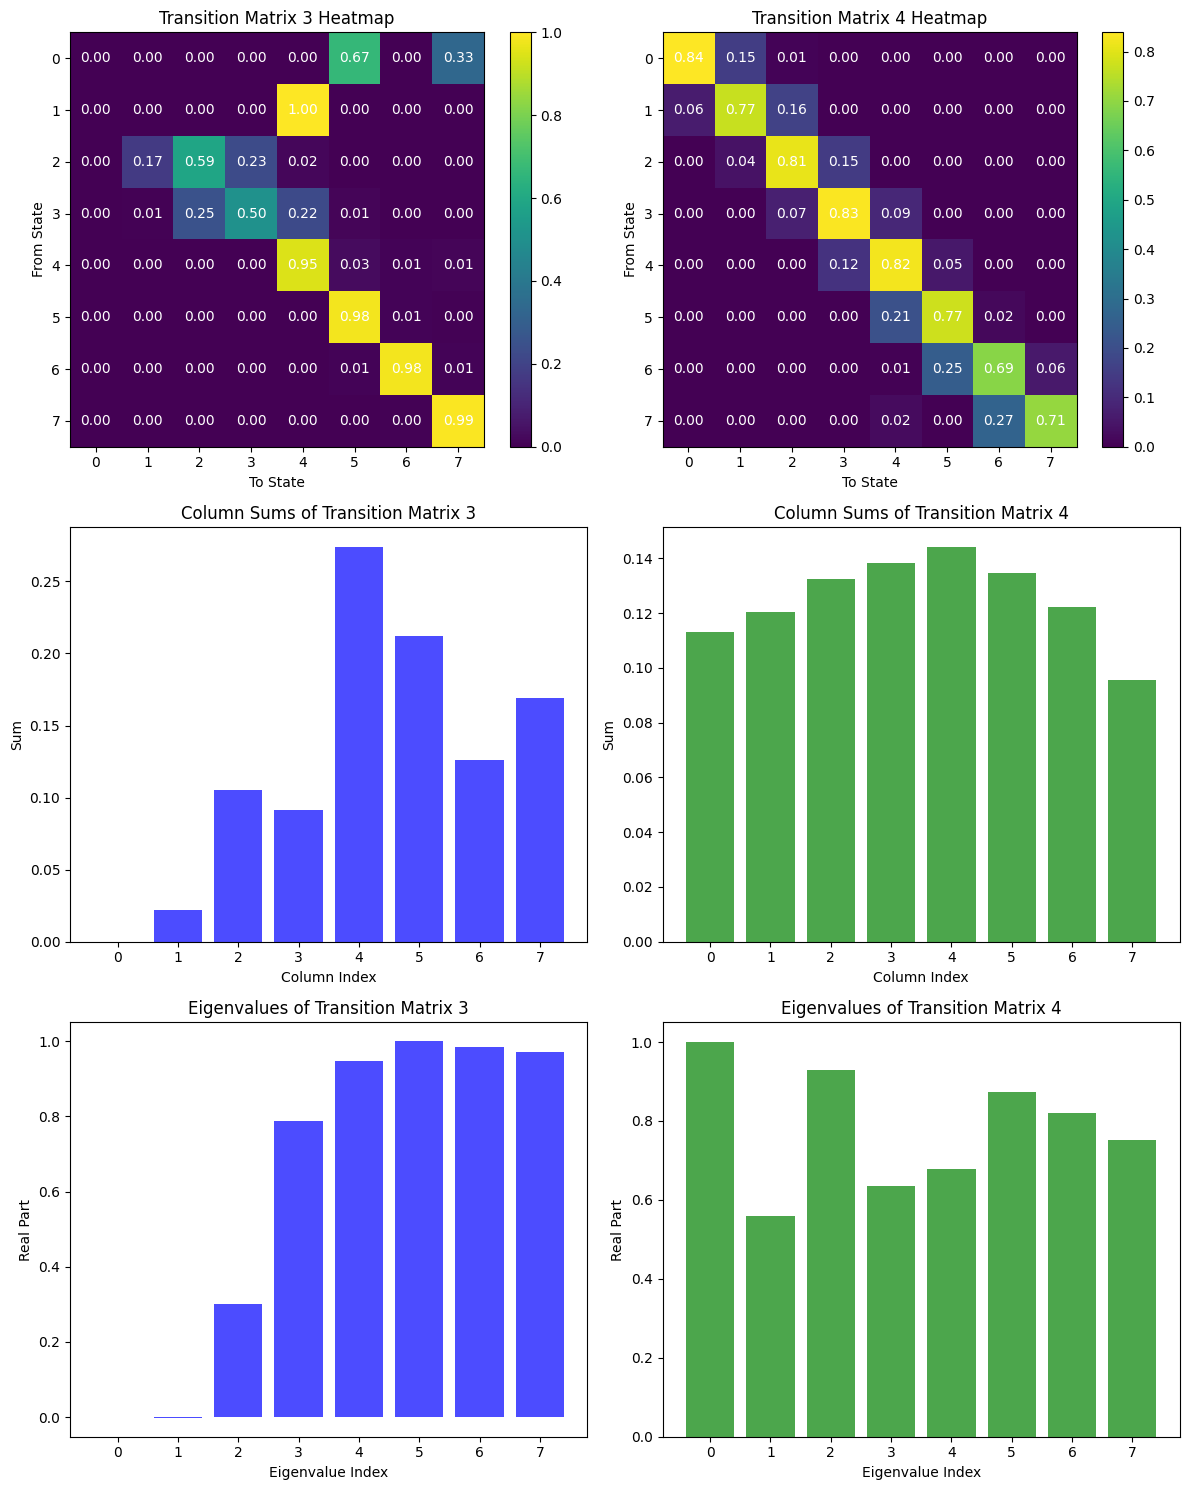

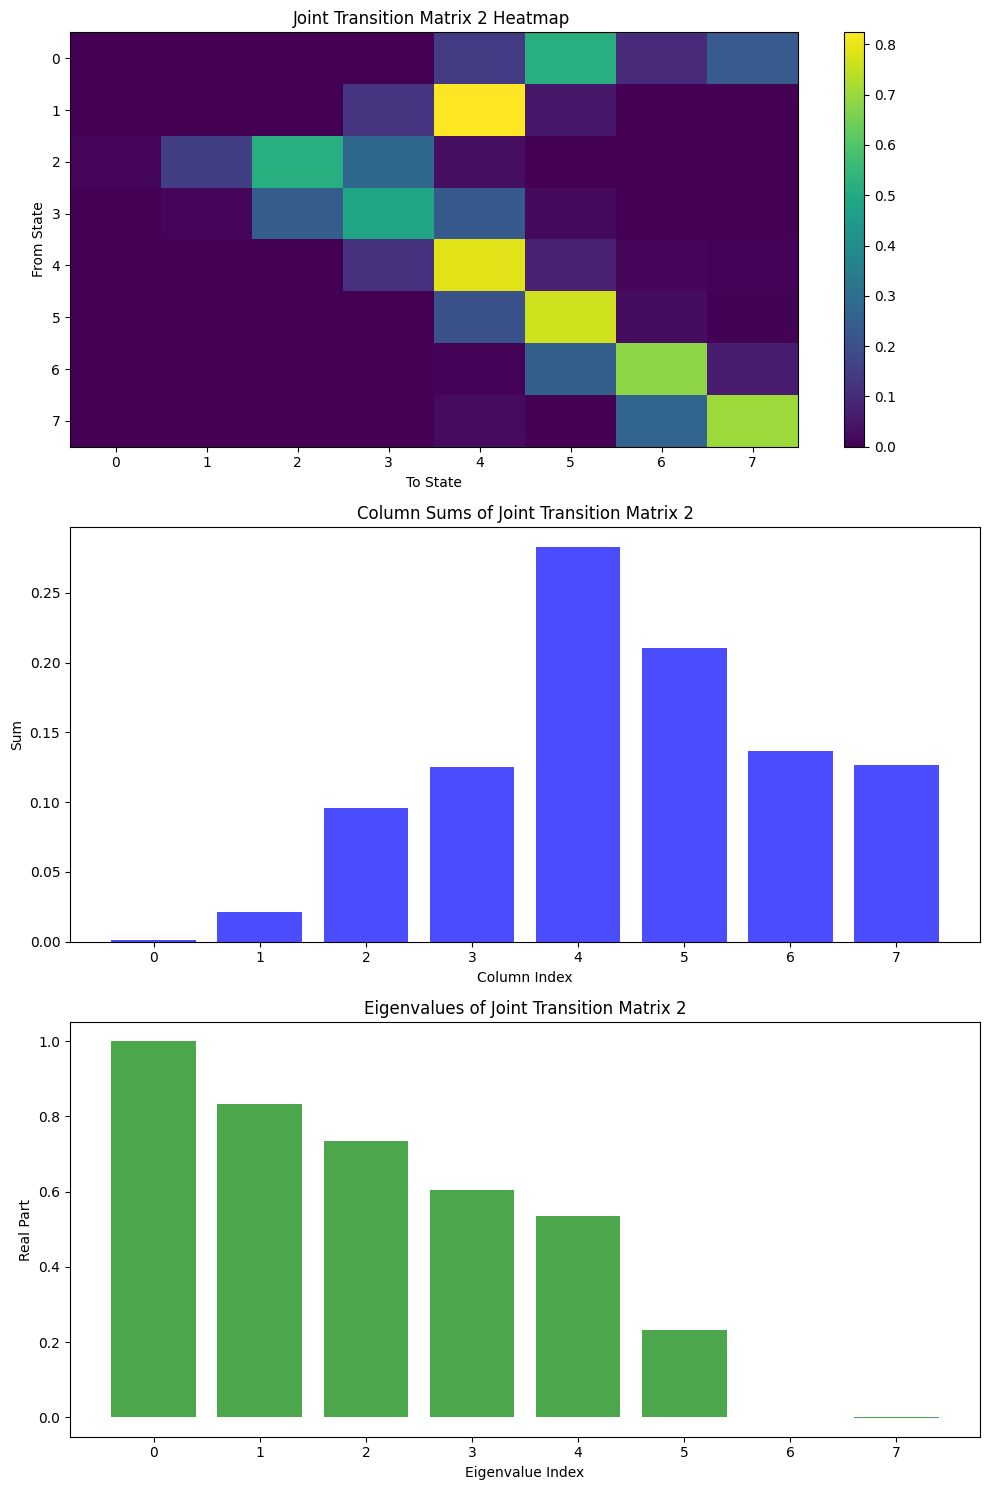

In [10]:

if __name__ == "__main__":
    join_matrixSecondCase = secondPair()[2]

    

# processing the conditional matrix between bot joint matrices 

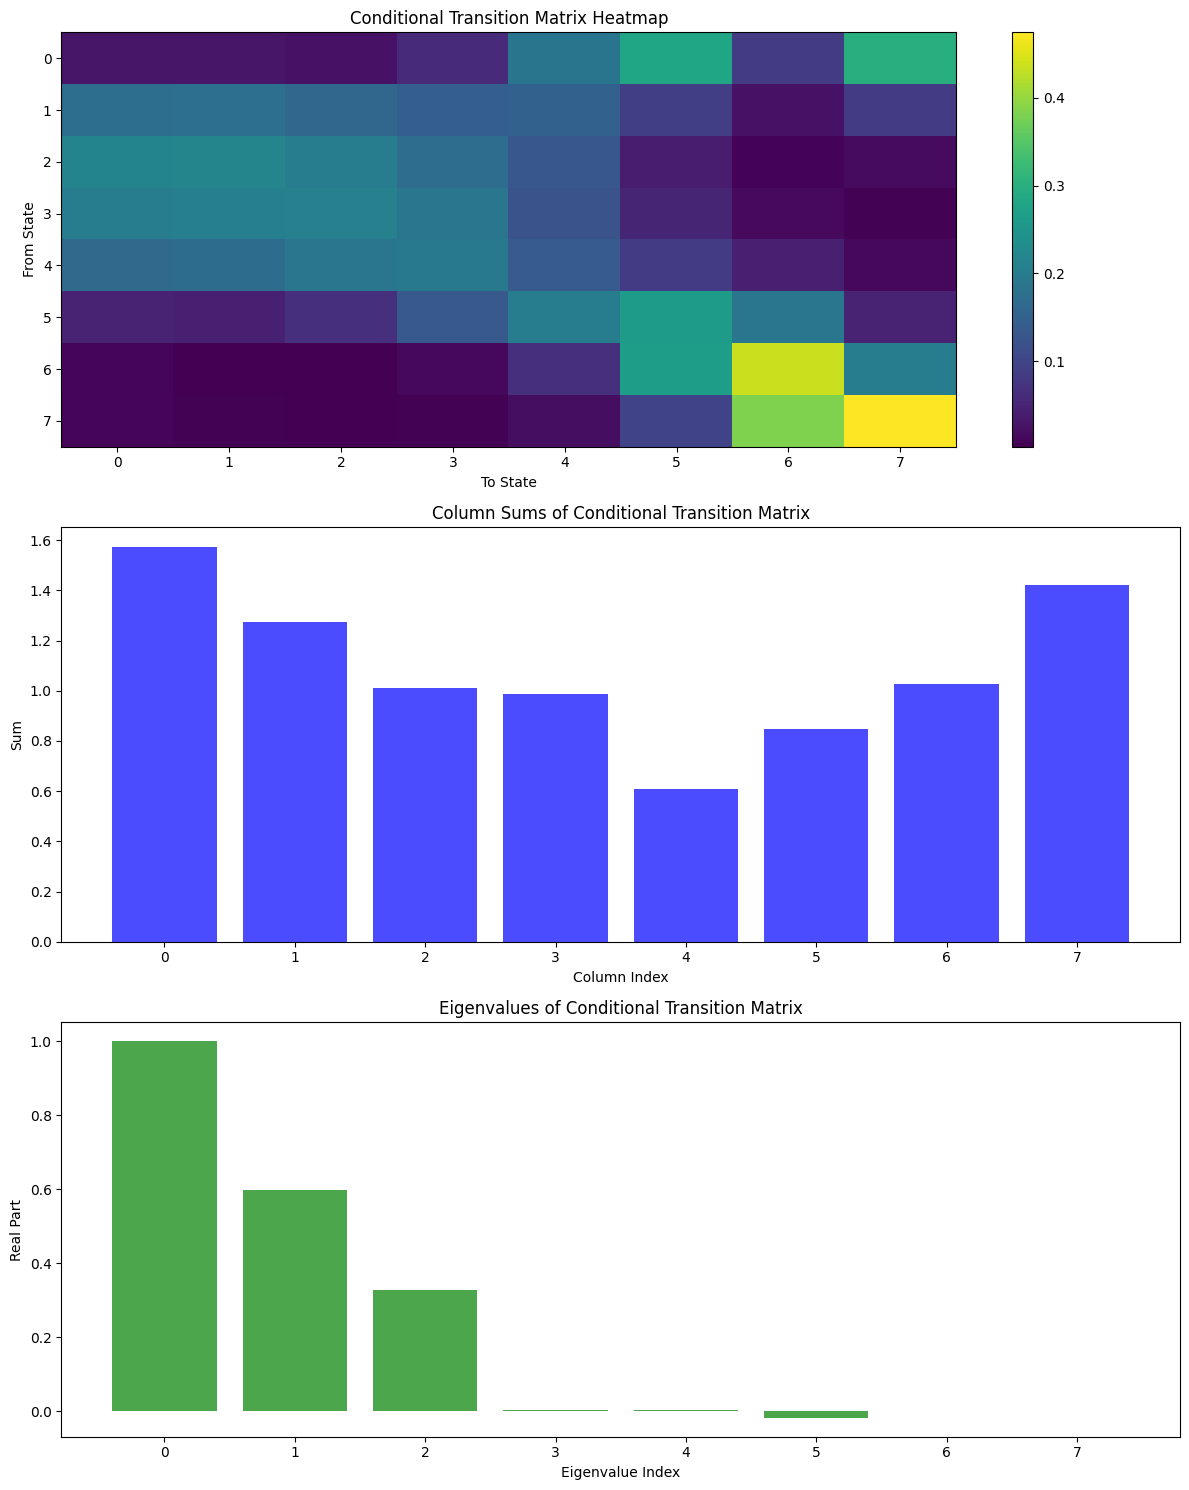

In [22]:

################################################################################
#### compute the conditional transition matrix between bot joint matrices
################################################################################

#compute the conditional from P(A|B) = P(A and B)/P(B) , donde A es mi primer par de series y b mi segundo par de matrices 

# Compute the conditional transition matrix
conditional_matrix = np.dot(join_matrixFirstCase,join_matrixSecondCase)
pb = np.sum(conditional_matrix, axis = 0, keepdims= True) # Sumar columnas para obtener P(B) 
conditional_matrix  = conditional_matrix/ pb   # Element-wise product
conditional_matrix /= conditional_matrix.sum(axis=1, keepdims=True)  # Normalize rows to sum to 1

# Compute column sums for the conditional matrix
column_sums_conditional = conditional_matrix.sum(axis=0)

# Compute eigenvalues for the conditional matrix
eigenvalues_conditional = np.linalg.eigvals(conditional_matrix)

# Plot heatmap, column sums, and eigenvalues for the conditional matrix
fig, axes = plt.subplots(3, 1, figsize=(12, 15))  # 3 rows, 1 column

# Heatmap for Conditional Transition Matrix
im = axes[0].imshow(conditional_matrix, cmap="viridis", aspect="auto")
axes[0].set_title("Conditional Transition Matrix Heatmap")
fig.colorbar(im, ax=axes[0])
axes[0].set_xlabel("To State")
axes[0].set_ylabel("From State")

# Calcular la suma promedio de las columnas de ambas matrices conjuntas
average_column_sums = (join_matrixFirstCase.sum(axis=0) + join_matrixSecondCase.sum(axis=0)) / 2

# Bar plot for Column Sums of Conditional Transition Matrix
axes[1].bar(range(N), column_sums_conditional / average_column_sums, color="blue", alpha=0.7)
axes[1].set_title("Column Sums of Conditional Transition Matrix")
axes[1].set_xlabel("Column Index")
axes[1].set_ylabel("Sum")

# Bar plot for Eigenvalues of Conditional Transition Matrix
axes[2].bar(range(len(eigenvalues_conditional)), eigenvalues_conditional.real, color="green", alpha=0.7)
axes[2].set_title("Eigenvalues of Conditional Transition Matrix")
axes[2].set_xlabel("Eigenvalue Index")
axes[2].set_ylabel("Real Part")

plt.tight_layout()
plt.show()


## making on it on torch :


In [12]:
"""

import torch
import matplotlib.pyplot as plt

def create_transition_matrix(series, num_states, device='cpu'):

    # Create a transition matrix from a time series using PyTorch.
    
    # Discretize the series into 'num_states' bins
    bins = torch.linspace(series.min(), series.max(), num_states + 1, device=device)
    states = torch.bucketize(series, bins) - 1  # Map to indices starting at 0
    states = torch.clamp(states, 0, num_states - 1)  # Ensure indices are in range

    # Initialize the transition matrix
    trans_matrix = torch.zeros((num_states, num_states), device=device)

    # Populate the transition matrix
    for i in range(len(states) - 1):
        from_state = states[i]
        to_state = states[i + 1]
        trans_matrix[from_state, to_state] += 1

    # Normalize rows to sum to 1
    row_sums = trans_matrix.sum(dim=1, keepdim=True)
    trans_matrix = trans_matrix / row_sums
    
    return trans_matrix

# Load your series (replace with actual data)
generation_solar =  df['generation solar'].values 
total_load_actual =  df['total load actual'].values 
generation_nuclear =  df['generation nuclear'].values 
price_actual = df['price actual'].values 


# Set parameters
num_states = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move series to the device
# Convertir las series de NumPy a tensores de PyTorch
generation_solar = torch.tensor(generation_solar, dtype=torch.float32).to(device)
total_load_actual = torch.tensor(total_load_actual, dtype=torch.float32).to(device)
generation_nuclear = torch.tensor(generation_nuclear, dtype=torch.float32).to(device)
price_actual = torch.tensor(price_actual, dtype=torch.float32).to(device)

# Create transition matrices
transition_matrix_1 = create_transition_matrix(generation_solar, num_states, device)
transition_matrix_2 = create_transition_matrix(total_load_actual, num_states, device)
transition_matrix_3 = create_transition_matrix(generation_nuclear, num_states, device)
transition_matrix_4 = create_transition_matrix(price_actual, num_states, device)

# Compute joint transition matrices
joint_matrix_1_2 = torch.mm(transition_matrix_1, transition_matrix_2)
joint_matrix_3_4 = torch.mm(transition_matrix_3, transition_matrix_4)

# Compute conditional transition matrices
conditional_matrix_1_2 = joint_matrix_1_2 / joint_matrix_1_2.sum(dim=1, keepdim=True)
conditional_matrix_3_4 = joint_matrix_3_4 / joint_matrix_3_4.sum(dim=1, keepdim=True)

# Plot results
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Heatmaps for joint matrices
im1 = axes[0, 0].imshow(joint_matrix_1_2.cpu().numpy(), cmap="viridis", aspect="auto")
axes[0, 0].set_title("Joint Matrix 1-2 Heatmap")
fig.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(joint_matrix_3_4.cpu().numpy(), cmap="viridis", aspect="auto")
axes[0, 1].set_title("Joint Matrix 3-4 Heatmap")
fig.colorbar(im2, ax=axes[0, 1])

# Heatmaps for conditional matrices
im3 = axes[1, 0].imshow(conditional_matrix_1_2.cpu().numpy(), cmap="viridis", aspect="auto")
axes[1, 0].set_title("Conditional Matrix 1-2 Heatmap")
fig.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(conditional_matrix_3_4.cpu().numpy(), cmap="viridis", aspect="auto")
axes[1, 1].set_title("Conditional Matrix 3-4 Heatmap")
fig.colorbar(im4, ax=axes[1, 1])

# Eigenvalues
eigenvalues_joint_1_2 = torch.linalg.eigvals(joint_matrix_1_2)
eigenvalues_joint_3_4 = torch.linalg.eigvals(joint_matrix_3_4)

axes[2, 0].bar(range(len(eigenvalues_joint_1_2)), eigenvalues_joint_1_2.real.cpu().numpy(), color="blue", alpha=0.7)
axes[2, 0].set_title("Eigenvalues of Joint Matrix 1-2")
axes[2, 0].set_xlabel("Eigenvalue Index")
axes[2, 0].set_ylabel("Real Part")

axes[2, 1].bar(range(len(eigenvalues_joint_3_4)), eigenvalues_joint_3_4.real.cpu().numpy(), color="green", alpha=0.7)
axes[2, 1].set_title("Eigenvalues of Joint Matrix 3-4")
axes[2, 1].set_xlabel("Eigenvalue Index")
axes[2, 1].set_ylabel("Real Part")

plt.tight_layout()
plt.show()"""

'\n\nimport torch\nimport matplotlib.pyplot as plt\n\ndef create_transition_matrix(series, num_states, device=\'cpu\'):\n\n    # Create a transition matrix from a time series using PyTorch.\n    \n    # Discretize the series into \'num_states\' bins\n    bins = torch.linspace(series.min(), series.max(), num_states + 1, device=device)\n    states = torch.bucketize(series, bins) - 1  # Map to indices starting at 0\n    states = torch.clamp(states, 0, num_states - 1)  # Ensure indices are in range\n\n    # Initialize the transition matrix\n    trans_matrix = torch.zeros((num_states, num_states), device=device)\n\n    # Populate the transition matrix\n    for i in range(len(states) - 1):\n        from_state = states[i]\n        to_state = states[i + 1]\n        trans_matrix[from_state, to_state] += 1\n\n    # Normalize rows to sum to 1\n    row_sums = trans_matrix.sum(dim=1, keepdim=True)\n    trans_matrix = trans_matrix / row_sums\n    \n    return trans_matrix\n\n# Load your series (repl